In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [3]:
import sys

additional_paths = ['../']

for path in additional_paths:
    if path not in sys.path:
        sys.path.append(path)

In [12]:
import utils.drnn_model
import utils.visualization
import utils.tf_helpers
import h5py
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import sacred

tf.__version__

'2.0.0'

In [8]:
hd = h5py.File('../../DQN/car_racing.hdf5', 'r')

In [9]:
hd.keys()

<KeysViewHDF5 ['action', 'observation', 'reward']>

(52, 90, 3)

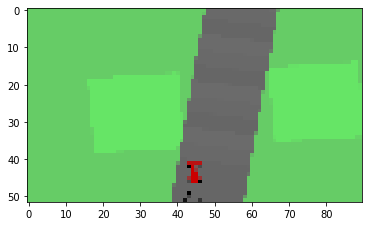

In [27]:
f = hd['observation'][0, 150, :350]
scale = 0.15
f = cv2.resize(f, (int(f.shape[1] * scale), int(f.shape[0] *  scale)))

plt.imshow(f)
f.shape

In [88]:
hd['observation'][0, 0].max() / 255

1.0

In [67]:
MIN_REWARD = hd['reward'][()].min()
MAX_REWARD = hd['reward'][()].max()

MIN_REWARD, MAX_REWARD

(-0.1, 8.788889)

In [104]:
ex = sacred.Experiment(name='DRNN Car Racing 1', interactive=True)

In [105]:
@ex.capture
def make_dataset(bs, W, H, SEQ_LEN):
    def data_input():
        actions = hd['action']
        rewards = hd['reward']
        observations = hd['observation']

        for i in range(len(observations)):
            o = observations[i, :SEQ_LEN] / 255.0
            o = np.array([cv2.resize(o_i, (W, H)) for o_i in o])

            a = actions[i, :SEQ_LEN]
            r = rewards[i, :SEQ_LEN]
            r = (r - MIN_REWARD) / (MAX_REWARD - MIN_REWARD)

            yield (a,), (o, r)

    return tf.data.Dataset.from_generator(
        data_input,
        output_types=((tf.float32,), (tf.float32, tf.float32)),
    ).repeat().batch(bs).prefetch(tf.data.experimental.AUTOTUNE)

In [106]:
list(make_dataset(3, 52, 90, 2).take(1))[0][1][0].shape

TensorShape([3, 2, 90, 52, 3])

In [107]:
@ex.config
def config():
    SEQ_LEN = 256
    W, H = 52, 90
    internal_size = 64
    batch_size = 128
    steps_per_epoch = 128
    lr = 0.005
    weight_decay = 0.0001
    should_preload_model = True

In [108]:
def on_batch_begin(model):
    utils.visualization.plot_pairwise_frames(
        sampler=lambda: list(make_dataset(1).take(1))[0],
        hypotheses=lambda x: model.net.predict(x)[0]
    )
    
    if 'loss' in model.net.history.history:
        loss = model.net.history.history['loss'][-1]
        ex.log_scalar('loss', loss)

    pred_rollout_name = 'pred_rollout.png'
    plt.savefig(pred_rollout_name)
    ex.add_artifact(pred_rollout_name)
    plt.show()

In [109]:
@ex.main
def main(
    SEQ_LEN,
    W, H,
    internal_size,
    batch_size,
    steps_per_epoch,
    lr,
    weight_decay,
    should_preload_model,
):
    #### Model
    model = utils.drnn_model.DRNN(internal_size=internal_size, W=W, H=H, lr=lr, weight_decay=weight_decay)
    model.net.summary()

    model_img_name = 'model.png'
    tf.keras.utils.plot_model(model.net, to_file=model_img_name, show_shapes=True, expand_nested=False, rankdir='TB', dpi=90)
    ex.add_artifact(model_img_name)
    
    #### Callbacks
    callbacks = [
#         utils.tf_helpers.model_persistor(
#             model,
#             should_preload_model=should_preload_model,
#             cp_file_name='cp-drnn-{epoch:0004d}-{loss:.5f}.hdf5'
#         ),
#         utils.tf_helpers.on_batch_begin(lambda: on_batch_begin(model)),
#         model.tb_callback,
    ]
    
    #### Training
    input_generator = make_dataset(bs=batch_size)
    model.net.fit_generator(
        generator=input_generator,
        validation_data=input_generator,
        validation_steps=2,
        steps_per_epoch=steps_per_epoch,
        epochs=2000,
        callbacks=callbacks
    )

In [ ]:
ex.run(config_updates={'should_preload_model': True})

WARNING - DRNN Car Racing 1 - No observers have been added to this run
INFO - DRNN Car Racing 1 - Running command 'main'
INFO - DRNN Car Racing 1 - Started


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
game_init (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
polar_to_cartesian (Lambda)     (None, 2)            0           game_init[0][0]                  
__________________________________________________________________________________________________
space_to_batch_gru1 (Lambda)    (None, None, 2)      0           user_input[0][0]                 
____________________________________________________________________________________________